In [18]:
#MNIST pair of digits recognition using CNN with simple hyperparameters tunning
#Yi Cong Li (20122756)
#this code is built using inpirations from:
#https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f
#https://www.tensorflow.org/tutorials/keras
#https://medium.com/@muhammetbolat/supervised-unsupervised-techniques-on-mnist-dataset-3f2ffd4c41c5
#https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html

#please make sure to run this code in default kaggle notebook environnment of competition, with Neural Network boosting GPU (ex. GPU T4 provided by Kaggle),
#otherwise it may take longer than 2 hours to complete, since it includes a simple hyperparameter search

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import sklearn
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner
from keras_tuner.tuners import BayesianOptimization

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import collections
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/classification-of-mnist-digits/train_result.csv
/kaggle/input/classification-of-mnist-digits/train.csv
/kaggle/input/classification-of-mnist-digits/test.csv


In [19]:
#loading train data
train_data = '/kaggle/input/classification-of-mnist-digits/train.csv'
df = pd.read_csv(train_data)
df = df.drop(['Unnamed: 1568'], axis = 1)
X_train = df.values

#loading test data
test_data = '/kaggle/input/classification-of-mnist-digits/test.csv'
df_test = pd.read_csv(test_data)
df_test = df_test.drop(['Unnamed: 1568'], axis = 1)
test_features = df_test.values

#loading train labels
train_result_data = '/kaggle/input/classification-of-mnist-digits/train_result.csv'
df_train_result = pd.read_csv(train_result_data)
y_train = df_train_result['Class'].to_numpy()

In [20]:
#Oversampling to fix the distribution issue
oversample = RandomOverSampler(sampling_strategy='not majority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [21]:
#one hot encoding
y_train = to_categorical(y_train)

In [22]:
#reshaping for convolutionnal layers
X_train = X_train.reshape(-1, 28, 56, 1)

In [23]:
#function to build model that allows tunning on learning rate
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(28, 56, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.6))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(19, activation='softmax', name='Output'))
    
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-3,5e-4,1e-4])
    opt = Adam(learning_rate = hp_learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [24]:
#Tuner using Bayesian optimization
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=4
)

In [25]:
#Hyperparameter tunning
tuner.search(X_train, y_train, epochs=30, validation_split=0.2)

Trial 4 Complete [00h 16m 24s]
val_accuracy: 0.9992883205413818

Best val_accuracy So Far: 0.9997810125350952
Total elapsed time: 01h 02m 44s


In [26]:
hyps = tuner.get_best_hyperparameters(1)[0]

In [28]:
#Use the best found hyperparameters to train and predict
model = tuner.hypermodel.build(hyps)
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
2284/2284 [==============================] - 32s 13ms/step - loss: 2.5197 - accuracy: 0.1760 - val_loss: 2.8633 - val_accuracy: 0.0000e+00
Epoch 2/30
2284/2284 [==============================] - 30s 13ms/step - loss: 1.6510 - accuracy: 0.3803 - val_loss: 2.0375 - val_accuracy: 0.2049
Epoch 3/30
2284/2284 [==============================] - 30s 13ms/step - loss: 1.2047 - accuracy: 0.5347 - val_loss: 1.4161 - val_accuracy: 0.5380
Epoch 4/30
2284/2284 [==============================] - 30s 13ms/step - loss: 0.8983 - accuracy: 0.6608 - val_loss: 1.0011 - val_accuracy: 0.5693
Epoch 5/30
2284/2284 [==============================] - 30s 13ms/step - loss: 0.6615 - accuracy: 0.7622 - val_loss: 0.5755 - val_accuracy: 0.8959
Epoch 6/30
2284/2284 [==============================] - 30s 13ms/step - loss: 0.5037 - accuracy: 0.8278 - val_loss: 0.4099 - val_accuracy: 0.9401
Epoch 7/30
2284/2284 [==============================] - 29s 13ms/step - loss: 0.3978 - accuracy: 0.8719 - val_loss: 0.29

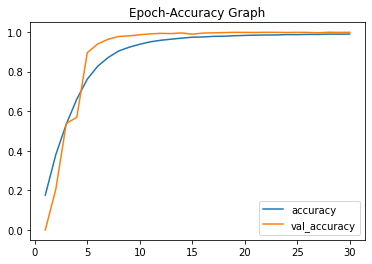

In [30]:
import matplotlib.pyplot as plt

plt.title('Epoch-Accuracy Graph')
plt.xlabel = 'Epochs'
plt.ylabel = 'Loss'
plt.plot(range(1, len(history.epoch) + 1), history.history['accuracy'])
plt.plot(range(1, len(history.epoch) + 1), history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()


In [29]:
test_features = test_features.reshape(-1, 28, 56, 1)
pred = model.predict(test_features)
pred_class = np.argmax(pred, axis = 1)
output = pd.DataFrame({'Index': np.arange(test_features.shape[0]), 'Class': pred_class})
output.to_csv('submission.csv', index=False)